In [288]:
# Import Crime data set
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from __future__ import print_function

# read in the csv file
df = pd.read_csv('data/Police_Incidents.csv')

# Reference: http://stackoverflow.com/questions/11346283/renaming-columns-in-pandas
# Removing spaces from headers

df.columns = [x.strip().replace(' ', '') for x in df.columns]
df.columns = [x.strip().replace('/', '') for x in df.columns]
df.columns = [x.strip().replace('(', '') for x in df.columns]
df.columns = [x.strip().replace(')', '') for x in df.columns]
df.columns = [x.strip().replace('-', '') for x in df.columns]

#df.head()

In [289]:
# Subset the dataset to year 2016
# Ref: http://stackoverflow.com/questions/18172851/deleting-dataframe-row-in-pandas-based-on-column-value

df = df[df.Year1ofOccurrence == 2016]

In [290]:
# Narrowing down our focus to the attributes mentioned in the Dataset 
# description by removing columns not used in analysis

for col in ['OffenseServiceNumber','ServiceNumberID','ReportingArea','Beat','Sector','CouncilDistrict',
            'DPDSwornMarshallsinvolved','ComplainantHomeAddress','ComplainantApartment','ComplainantZipCode',
            'ComplainantCity','ComplainantState','ComplainantBusinessName','ComplainantBusinessAddress',
            'YearAssignment','Weather','RespondingOfficer#1BadgeNo','RespondingOfficer#1Name','RespondingOfficer#2BadgeNo',
            'RespondingOfficer#2Name','ReportingOfficerBadgeNo','AssistingOfficerBadgeNo','ReviewingOfficerBadgeNo',
            'ElementNumberAssigned','InvestigatingUnit1','InvestigatingUnit2','SpecialReportPreRMS','UCRDisposition',
            'UCR1','UCR2PreRMS','FinalUCR','RMSCode','CJISCode','PenalCode','HateCrime','VictimPackage', 'UpdateDate',
            'ModusOperandiMO', 'OffenseCodeCC', 'VictimInjuryDescription', 'OffenseStatus', 
            'ComplainantAgeatOffense', 'ComplainantAge', 'ComplainantGender', 'ComplainantRace', 'ComplainantName',
           'OffenseEnteredDateTime', 'OffenseEnteredTime', 'OffenseEnteredDayoftheWeek', 'OffenseEnteredMonth', 
            'OffenseEnteredYear', 'Dateincidentcreated', 'MapDate', 'Day2oftheYear','IncidentNumberwoYear', 'YearofIncident',
           'IncidentNumberwYear', 'Call911Problem', 'StreetBlock', 'StreetDirection', 'StreetName', 
           'IncidentAddress', 'ApartmentNumber', 'ZipCode', 'City', 'State', 'XCoordinate', 'YCoordinate', 'TargetAreaActionGrids', 
           'Community', 'Date1ofOccurrence', 'Date2ofOccurrence', 'Year2ofOccurrence', 'Month2ofOccurence', 'Day2oftheWeek', 
            'Time2ofOccurrence', 'StartingDateTime', 'EndingDateTime', 'DateofReport','CallDateTime',
            'TypeofProperty', 'IncidentNumberwYear', 'Year1ofOccurrence', 'Day1oftheYear', 'TypeofIncident','UCROffenseName',
           'OffenseType','FamilyOffense','PersonInvolvementType','TypeofLocation','VictimCondition','UCROffenseDescription']:
    if col in df:
        del df[col]
        
#Let's get the specs of our subsetted data:
print (df.info())       

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99341 entries, 0 to 196036
Data columns (total 11 columns):
Watch                   99341 non-null object
PenaltyClass            84593 non-null object
Division                99321 non-null object
Month1ofOccurence       99341 non-null object
Day1oftheWeek           99341 non-null object
Time1ofOccurrence       99341 non-null object
CallReceivedDateTime    99328 non-null object
CallClearedDateTime     99310 non-null object
CallDispatchDateTime    99319 non-null object
GangRelatedOffense      99339 non-null object
DrugRelatedIncident     99339 non-null object
dtypes: object(11)
memory usage: 9.1+ MB
None


In [291]:
# Convert to date and time fields
# Note: Takes long to run, might be a quicker method to do this conversion
# Reference: http://stackoverflow.com/questions/16852911/how-do-i-convert-dates-in-a-pandas-data-frame-to-a-date-data-type
df['CallReceivedDateTime'] = pd.to_datetime(df['CallReceivedDateTime'])
df['CallClearedDateTime'] = pd.to_datetime(df['CallClearedDateTime'])
df['CallDispatchDateTime'] = pd.to_datetime(df['CallDispatchDateTime'])

In [292]:
# Compute the time between call received and call displatched, call Displatch and call cleared.
# Reference: http://www.itgo.me/a/x791470639852744898/calculate-pandas-dataframe-time-difference-between-two-columns-in-hours-and-minu
df['rec_disp_time_m'] = (df['CallDispatchDateTime'] - df['CallReceivedDateTime']).astype('timedelta64[m]')
df['disp_clear_time_m'] = (df['CallClearedDateTime'] - df['CallDispatchDateTime']).astype('timedelta64[m]')

# Remove rows with negative time difference
df = df[df.disp_clear_time_m >= 0]
df = df[df.rec_disp_time_m >= 0]

# Create Hour of Occurrence from Time Occurrence 
# Ref: http://stackoverflow.com/questions/25789445/pandas-make-new-column-from-string-slice-of-another-column
df['Hour'] = df.Time1ofOccurrence.str[:2]
df['Hour'] = (df['Hour']).astype('int64')

# Retrieve first character of penalty class as only F for felony or M misdemeanor
df['Penalty'] = df.PenaltyClass.str[:1]

# Change day of week to indicate weekend   
df['IsWeekend'] = (df['Day1oftheWeek'] == 'Sat') | (df['Day1oftheWeek'] == 'Fri') | (df['Day1oftheWeek'] == 'Sun')
df.IsWeekend = df.IsWeekend.astype(np.int)

# change Gang Related attribute to a more usable value
df['IsGangRelated'] = df.GangRelatedOffense == 'Yes'
df.IsGangRelated = df.IsGangRelated.astype(np.int)

# change Drug Related attribute to a more usable value
df['IsDrugRelated'] = df.DrugRelatedIncident == 'Yes'
df.IsDrugRelated = df.IsDrugRelated.astype(np.int)
        
# Remove call datetime call columns
for col in ['CallReceivedDateTime','CallClearedDateTime','CallDispatchDateTime','Time1ofOccurrence',
            'PenaltyClass','Day1oftheWeek','GangRelatedOffense','DrugRelatedIncident']:
    if col in df:
        del df[col]
        
#df.head()

In [273]:
df.to_csv('Police_Incidents_mini.csv', sep=',', encoding='utf-8')

In [293]:
# creating missing values grouping by day of week and watch
df_grouped = df.groupby(by=['Month1ofOccurence','Watch'])

# Using grouping to impute data in each group and then transform back 
# Impute missing numerical values 
df_imputed = df_grouped.transform(lambda grp: grp.fillna(grp.median()))

# Impute missing categorical values
# Ref: http://stackoverflow.com/questions/32617811/imputation-of-missing-values-for-categories-in-pandas
df_imputed['Penalty'] = df_grouped.Penalty.fillna(df['Penalty'].value_counts().index[0])
df_imputed['Division'] = df_grouped.Division.fillna(df['Division'].value_counts().index[0])

# Filling the grouped variables from original data frame
df_imputed[['Month1ofOccurence','Watch']] = df[['Month1ofOccurence','Watch']]

In [294]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99296 entries, 0 to 196036
Data columns (total 10 columns):
rec_disp_time_m      99296 non-null float64
disp_clear_time_m    99296 non-null float64
Hour                 99296 non-null int64
IsWeekend            99296 non-null int64
IsGangRelated        99296 non-null int64
IsDrugRelated        99296 non-null int64
Penalty              99296 non-null object
Division             99296 non-null object
Month1ofOccurence    99296 non-null object
Watch                99296 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 8.3+ MB


In [295]:
# Adding variable for logistic regression based on time from call received to call dispatched
##### need to add 
#df_imputed.rec_disp_time_m < 30


# Generating dummy variables from categorical variables
# create dummy variables for Penalty
tmp_df = pd.get_dummies(df_imputed.Penalty,prefix='Penalty')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe

# create dummy variables for Division
tmp_df = pd.get_dummies(df_imputed.Division,prefix='Division')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe

# create dummy variables for Watch
tmp_df = pd.get_dummies(df_imputed.Watch,prefix='Watch')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe

# create dummy variables for Month of Occurence
tmp_df = pd.get_dummies(df_imputed.Month1ofOccurence,prefix='Month1ofOccurence')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe

# Remove columns used for dummy variables
for col in ['Month1ofOccurence','Watch','Division','Penalty']:
    if col in df_imputed:
        del df_imputed[col]

df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99296 entries, 0 to 196036
Data columns (total 32 columns):
rec_disp_time_m                99296 non-null float64
disp_clear_time_m              99296 non-null float64
Hour                           99296 non-null int64
IsWeekend                      99296 non-null int64
IsGangRelated                  99296 non-null int64
IsDrugRelated                  99296 non-null int64
Penalty_F                      99296 non-null uint8
Penalty_M                      99296 non-null uint8
Penalty_N                      99296 non-null uint8
Division_Central               99296 non-null uint8
Division_North Central         99296 non-null uint8
Division_NorthEast             99296 non-null uint8
Division_NorthWest             99296 non-null uint8
Division_South Central         99296 non-null uint8
Division_SouthEast             99296 non-null uint8
Division_SouthWest             99296 non-null uint8
Watch_1                        99296 non-null uint8
Wa

In [303]:
df_imputed['IsSlowResponse'] = df_imputed.rec_disp_time_m > 30
df_imputed.IsSlowResponse = df_imputed.IsSlowResponse.astype(np.int)
for col in ['rec_disp_time_m']:
    if col in df_imputed:
        del df_imputed[col]

In [304]:
#df_imputed.to_csv('Police_Incidents_imputed.csv', sep=',', encoding='utf-8')
df_imputed.head(10)

,disp_clear_time_m,Hour,IsWeekend,IsGangRelated,IsDrugRelated,Penalty_F,Penalty_M,Penalty_N,Division_Central,Division_North Central,...,Month1ofOccurence_February,Month1ofOccurence_January,Month1ofOccurence_July,Month1ofOccurence_June,Month1ofOccurence_March,Month1ofOccurence_May,Month1ofOccurence_November,Month1ofOccurence_October,Month1ofOccurence_September,IsSlowResponse
0,207.0,23,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,207.0,23,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,207.0,23,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,439.0,12,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,122.0,23,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,56.0,0,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
16,78.0,23,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
17,91.0,0,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
19,526.0,0,1,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
20,526.0,0,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


# Training and Testing Split

In [305]:
#####  haven't started yet

from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'IsSlowResponse' in df_imputed:
    y = df_imputed['IsSlowResponse'].values # get the labels we want
    del df_imputed['IsSlowResponse'] # get rid of the class label
    X = df_imputed.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(X)
print(y)
print(num_instances)

[[ 207.   23.    1. ...,    0.    0.    0.]
 [ 207.   23.    1. ...,    0.    0.    0.]
 [ 207.   23.    1. ...,    0.    0.    0.]
 ..., 
 [ 103.   19.    0. ...,    0.    0.    0.]
 [  75.   12.    0. ...,    0.    0.    0.]
 [ 163.    0.    0. ...,    0.    0.    0.]]
[0 0 0 ..., 1 1 1]
99296


# Logistic Regression

In [310]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

====Iteration 0  ====
accuracy 0.721550855992
confusion matrix
 [[14296    41]
 [ 5489    34]]
====Iteration 1  ====
accuracy 0.722608257805
confusion matrix
 [[14312    31]
 [ 5478    39]]
====Iteration 2  ====
accuracy 0.723867069486
confusion matrix
 [[14334    40]
 [ 5444    42]]


In [311]:
# this does the exact same thing as the above block of code, but with shorter syntax

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

====Iteration 0  ====
accuracy 0.722004028197
confusion matrix
 [[14299    35]
 [ 5486    40]]
====Iteration 1  ====
accuracy 0.719989929507
confusion matrix
 [[14263    30]
 [ 5531    36]]
====Iteration 2  ====
accuracy 0.726636455186
confusion matrix
 [[14400    29]
 [ 5400    31]]


In [312]:
# and here is an even shorter way of getting the accuracies for each training and test set
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object) # this also can help with parallelism
print(accuracies)

[ 0.72220544  0.72749245  0.71873112]


In [313]:
# here we can change some of the parameters interactively
from ipywidgets import widgets as wd

def lr_explor(cost):
    lr_clf = LogisticRegression(penalty='l2', C=cost, class_weight=None) # get object
    accuracies = cross_val_score(lr_clf,X,y=y,cv=cv_object) # this also can help with parallelism
    print(accuracies)

wd.interact(lr_explor,cost=(0.001,5.0,0.05),__manual=True)

[ 0.72643505  0.72109768  0.72578046]


# Interpretting Weights

In [314]:
# interpret the weights

# iterate over the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df_imputed.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])
    
# does this look correct? 

disp_clear_time_m has weight of -9.23050502752e-05
Hour has weight of 0.0293000537013
IsWeekend has weight of 0.138571925971
IsGangRelated has weight of -0.450795285751
IsDrugRelated has weight of -1.58315812089
Penalty_F has weight of -0.265793855661
Penalty_M has weight of -0.333248701959
Penalty_N has weight of -0.11027468282
Division_Central has weight of -0.254205146825
Division_North Central has weight of -0.35890318777
Division_NorthEast has weight of -0.0905868194456
Division_NorthWest has weight of 0.0975527891939
Division_South Central has weight of -0.0389682123205
Division_SouthEast has weight of -0.127860360507
Division_SouthWest has weight of 0.0636536972344
Watch_1 has weight of -0.0918127234767
Watch_2 has weight of -0.19814563083
Watch_3 has weight of -0.524667820626
Watch_U has weight of 0.105308934493
Month1ofOccurence_April has weight of -0.0881857329026
Month1ofOccurence_August has weight of -0.206743020453
Month1ofOccurence_December has weight of 0.131507083877
Mo

In [315]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05) # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df_imputed.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

accuracy: 0.723967774421
[[14336    38]
 [ 5444    42]]
IsDrugRelated has weight of -0.20486073426
Watch_3 has weight of -0.138600819826
disp_clear_time_m has weight of -0.122375672274
Month1ofOccurence_March has weight of -0.0829177091439
Month1ofOccurence_June has weight of -0.0824365422985
Division_North Central has weight of -0.0814782292451
Division_Central has weight of -0.0518429847971
IsGangRelated has weight of -0.0457537796516
Month1ofOccurence_February has weight of -0.0450657041205
Month1ofOccurence_May has weight of -0.044679621515
Month1ofOccurence_August has weight of -0.0396550290663
Month1ofOccurence_January has weight of -0.0206808746706
Division_SouthEast has weight of -0.0160645375348
Penalty_M has weight of -0.014221359689
Month1ofOccurence_April has weight of -0.00123034385862
Penalty_N has weight of 0.00450883388612
Watch_2 has weight of 0.00708654979068
Division_NorthEast has weight of 0.00784802872427
Division_South Central has weight of 0.0122210417585
Penalty

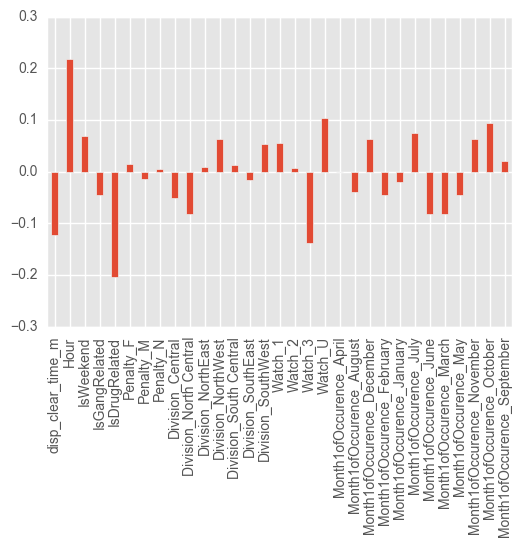

In [316]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=df_imputed.columns)
weights.plot(kind='bar')
plt.show()

# LEFT OFF HERE

In [ ]:
from sklearn.preprocessing import StandardScaler
# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)

from sklearn.pipeline import Pipeline
# you can apply the StandardScaler function inside of the cross-validation loop 
#  but this requires the use of PipeLines in scikit. 
#  A pipeline can apply feature pre-processing and data fitting in one compact notation
#  Here is an example!

std_scl = StandardScaler()
lr_clf = LogisticRegression(penalty='l2', C=0.05) 

# create the pipline
piped_object = Pipeline([('scale', std_scl),  # do this
                         ('logit_model', lr_clf)]) # and then do this

weights = []
# run the pipline cross validated
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    piped_object.fit(X[train_indices],y[train_indices])  # train object
    # it is a little odd getting trained objects from a  pipeline:
    weights.append(piped_object.named_steps['logit_model'].coef_[0])
    

weights = np.array(weights)


In [ ]:
import plotly
plotly.offline.init_notebook_mode() # run at the start of every notebook

error_y=dict(
            type='data',
            array=np.std(weights,axis=0),
            visible=True
        )

graph1 = {'x': df_imputed.columns,
          'y': np.mean(weights,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars'}

plotly.offline.iplot(fig)

## DELETE variables we don't need next...

In [ ]:
Xnew = df_imputed[['Age','Pclass','IsMale']].values

weights = []
# run the pipline corssvalidated
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(Xnew,y)):
    piped_object.fit(Xnew[train_indices],y[train_indices])  # train object
    weights.append(piped_object.named_steps['logit_model'].coef_[0])
    
weights = np.array(weights)

error_y=dict(
            type='data',
            array=np.std(weights,axis=0),
            visible=True
        )

graph1 = {'x': ['Age','Pclass','IsMale'],
          'y': np.mean(weights,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars'}

plotly.offline.iplot(fig)

# Support Vector Machines

In [ ]:
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test)

In [ ]:

# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)


In [ ]:

# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )


In [ ]:

# if using linear kernel, these make sense to look at (not otherwise, why?)
print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=df_imputed.columns)
weights.plot(kind='bar')


In [ ]:

# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)

# make a dataframe of the training data
df_tested_on = df_imputed.iloc[train_indices] # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:]

df_support['Survived'] = y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
df_imputed['Survived'] = y # also add it back in for the original data
df_support.info()


# Gradient Based Alternatives

In [ ]:
# here is where the online tutorial code stops and my code starts
print(X.shape)
print(y.shape)

In [ ]:
# now divide the data into test and train using scikit learn built-ins
from sklearn.model_selection import StratifiedShuffleSplit 

cv = StratifiedShuffleSplit( n_splits=1,test_size=0.5)

In [ ]:
# use some compact notation for creating a linear SVM classifier with stichastic descent
from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    svm_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('SVM:', acc)

In [ ]:
# use some compact notation for creating a logistic regression classifier with stochastic descent
log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    log_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('Logistic Regression:', acc)

In [ ]:

# now lets use some of what we know from this class to reduce the dimensionality of the set
from sklearn.decomposition import PCA
n_components = 50

pca = PCA(n_components=n_components, svd_solver='randomized')

iterations = 150
log_sgd = SGDClassifier(
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter=iterations, n_jobs=-1, penalty='l2')

# you could also set this up in a pipeline
for train_idx, test_idx in cv.split(X,y):
    log_sgd.fit(pca.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(pca.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('Logistic Regression:', acc)
